In [712]:
import os.path

import astropy.table
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from astropy.io import fits,ascii
import pandas as pd
import cmasher as cmr
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import pingouin

In [713]:
sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_s05.csv")
onere = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_1Re.csv")
prospect = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
galfit = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_GalfitSersicCat_v0.1.csv")
ssp = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
bpt = pd.read_csv('/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv')
master = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_master_source_catalogue.csv",skiprows=16)
prospect = prospect[prospect['MAGPIID'].isin(onere["MAGPIID"])]
galfit = galfit[galfit["MAGPIID"].isin(onere["MAGPIID"])]
bpt = bpt[bpt["MAGPIID"].isin(onere["MAGPIID"])]
ssp = ssp[ssp["MAGPIID"].isin(onere["MAGPIID"])]
master = master[master['MAGPIID'].isin(onere["MAGPIID"])]
sample = sample[sample["MAGPIID"].isin(onere["MAGPIID"])]

/var/folders/hn/phg07l9934x4013mnrp122c40000gn/T/ipykernel_8734/2078251302.py:58: RuntimeWarning: divide by zero encountered in log10
  ax2.hist(np.log10(re2), label="All Galaxies", color="k", alpha=0.2, zorder=1,bins=np.arange(1,4,0.20))
/var/folders/hn/phg07l9934x4013mnrp122c40000gn/T/ipykernel_8734/2078251302.py:58: RuntimeWarning: invalid value encountered in log10
  ax2.hist(np.log10(re2), label="All Galaxies", color="k", alpha=0.2, zorder=1,bins=np.arange(1,4,0.20))


10.738489740982777
9.376161303652186
2.35
3.0303738317757003
471.3371816298457
592.7618392808502


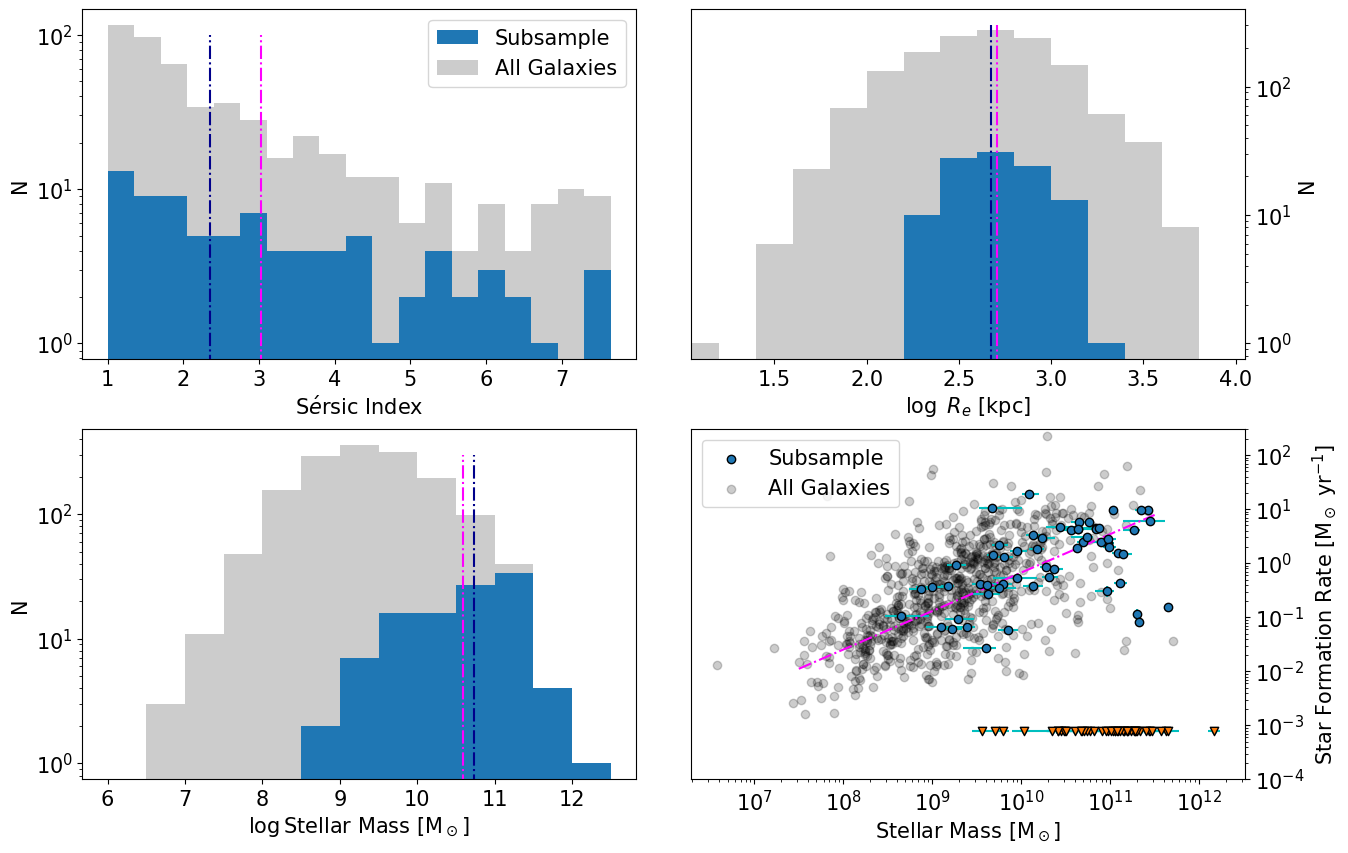

In [714]:
# sample = pd.read_csv("MAGPI_Emission_Lines/kinemetry_sample_M2.csv")
# sample = sample[sample['v_asym_15re']<0.1]
# sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample.csv")

sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_s05.csv")
# SFMS & Mass
t = ascii.read("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_Balmer_SFRs_onedspec.tbl")
df=pd.DataFrame({"MAGPIID":np.array(t['MAGPI_ID']),
                "SFR":np.array(t["SFR"]),
                "SFR_err":np.array(t["SFR_err"])})
df1 = df[df["MAGPIID"].isin(sample["MAGPIID"])]
df2 = df[~df["MAGPIID"].isin(sample["MAGPIID"])]
SFR = df1["SFR"].to_numpy()
bpt = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv")
#SFR = bpt["SFR, dust corrected"].to_numpy()
SFR_err = df1["SFR_err"].to_numpy()
SFR_2 = df2["SFR"].to_numpy()
SFR[np.isnan(SFR)]=10**(-3.1)
prospect = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
M_sol = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]["StellarMass_median"].to_numpy()
mass_err_16 = M_sol-prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]["StellarMass_16"].to_numpy()
mass_err_84 = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]["StellarMass_84"].to_numpy()-M_sol
M_sol_2 = prospect[prospect["MAGPIID"].isin(df2["MAGPIID"].to_numpy())]["StellarMass_median"].to_numpy()
xx = np.logspace(7.5,11.5, 107)
MS = (xx**0.712)*(10**-7.293)
# Sersic
galfit = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_GalfitSersicCat_v0.1.csv")
galfit = galfit[~galfit["MAGPIID"].isin(sample["MAGPIID"])]
n2 = galfit["n"]
n2 = n2[n2 > 0]
re2 = galfit["re"].to_numpy()
#re2[re2==0]=np.nan
dl = cosmo.luminosity_distance(galfit["z"].to_numpy()).to(u.kpc).value
re2 = (re2/3600)*dl
galfit = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_GalfitSersicCat_v0.1.csv")
galfit = galfit[galfit["MAGPIID"].isin(sample["MAGPIID"])]
n = galfit["n"]
n = n[n > 0]
re = galfit["re"].to_numpy()
dl = cosmo.luminosity_distance(galfit["z"].to_numpy()).to(u.kpc).value
re = (re/3600)*dl

plt.rcParams.update({"font.size":15})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
# Sersic
ax1.hist(n, zorder=2, label="Subsample", bins=np.arange(1,8,0.35))
ax1.hist(n2, label="All Galaxies", color="k", bins=np.arange(1,8,0.35), alpha=0.2)
ax1.vlines(np.median(n), ymin=0, ymax=100,color="darkblue",ls="dashdot")
ax1.vlines(np.mean(n), ymin=0, ymax=100,color="fuchsia",ls="dashdot")
#ax.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylabel("N")
ax1.set_xlabel(r"S$\'{e}$rsic Index")
ax1.legend()
# Environment
ax2.hist(np.log10(re), label="Subsample", zorder=2,bins=np.arange(1,4,0.20))
#ax2.hist(N_Gals_0, zorder=2, label="No Env. Metrics")
ax2.hist(np.log10(re2), label="All Galaxies", color="k", alpha=0.2, zorder=1,bins=np.arange(1,4,0.20))
ax2.set_yscale("log")
ax2.set_xlabel(r"$\log$ $R_e$ [kpc]")
ax2.vlines(np.median(np.log10(re)), ymin=0, ymax=300,color="darkblue",linestyles="dashdot")
ax2.vlines(np.mean(np.log10(re)),ymin=0, ymax=300,color="fuchsia",ls="dashdot")
ax2.set_ylabel("N")
#ax2.legend()
ax2.set_xlim(1.05,4.05)
# Mass
ax3.hist(np.log10(M_sol), zorder=2, label="Subsample", bins=np.arange(6,13,0.5))
ax3.hist(np.log10(M_sol_2), label="All Galaxies", color="k", bins=np.arange(6,13,0.5), alpha=0.2)
ax3.vlines(np.median(np.log10(M_sol)), ymin=0, ymax=300,color="darkblue",ls="dashdot")
ax3.vlines(np.mean(np.log10(M_sol)), ymin=0, ymax=300,color="fuchsia",ls="dashdot")
ax3.set_ylabel("N")
ax3.set_yscale("log")
ax3.set_xlabel(r"$\log$Stellar Mass [M$_\odot$]")
#ax3.legend()
# SFMS
ax4.scatter(M_sol[SFR>10**(-3)], SFR[SFR>10**(-3)], zorder=3, label="Subsample", ec="k")
ax4.scatter(M_sol[SFR<10**(-3)], SFR[SFR<10**(-3)], zorder=3, ec="k",marker="v")
ax4.errorbar(M_sol, SFR, xerr=[mass_err_16,mass_err_84], yerr=SFR_err, zorder=2, fmt=".c", ls="")
ax4.scatter(M_sol_2, SFR_2, zorder=1, alpha=0.2, c="k", label="All Galaxies")
ax4.plot(xx, MS, ls="dashdot", c="magenta")
ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.set_ylim(1e-4, 300)
ax4.set_xlabel(r"Stellar Mass [M$_\odot$]")
ax4.set_ylabel(r"Star Formation Rate [M$_\odot$ yr$^{-1}$]")
ax4.legend()
for ax in [ax2, ax4]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/SFMS_Mass_Sersic_Env.pdf", bbox_inches="tight")
print(np.median(np.log10(M_sol)))
print(np.mean(np.log10(M_sol_2)))
print(np.median(n))
print(np.mean(n))
print(np.median(re))
print(np.mean(re))

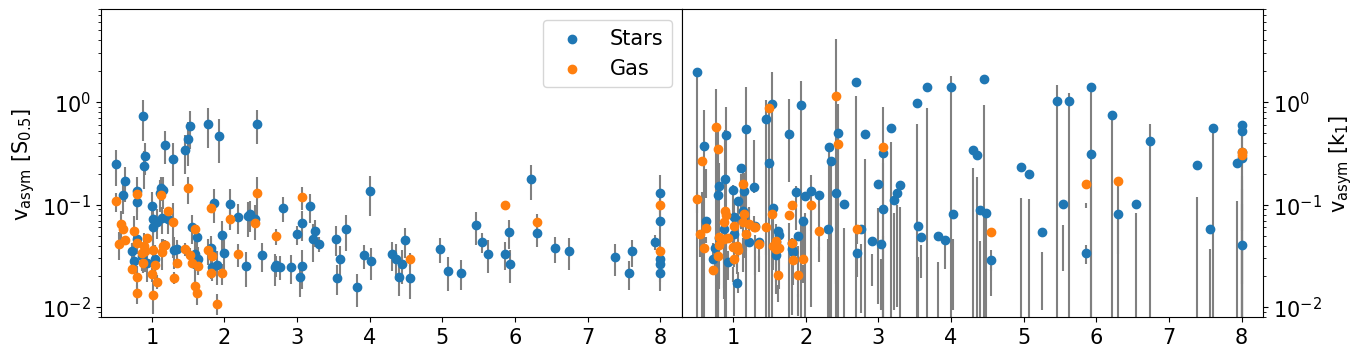

In [715]:
onre = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_1Re.csv")
sample = sample[sample["MAGPIID"].isin(onre["MAGPIID"])]
galfit = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_GalfitSersicCat_v0.1.csv")
galfit = galfit[galfit["MAGPIID"].isin(onre["MAGPIID"])]
vs_s05 = sample["v_asym_s"].to_numpy()
vs_s05_err=sample["v_asym_s_err"].to_numpy()
vg_s05 = sample["v_asym_g"].to_numpy()
vg_s05_err=sample["v_asym_g_err"].to_numpy()
vs_onere = onere["v_asym_s"].to_numpy()
vs_onere_err = onere["v_asym_s_err"].to_numpy()
vg_onere = onere["v_asym_g"].to_numpy()
vg_onere_err = onere["v_asym_g_err"].to_numpy()
n = galfit["n"].to_numpy()
fig,ax = plt.subplots(1,2,figsize=(15,4))
ax[0].scatter(n,vs_s05,zorder=2,label="Stars")
ax[0].scatter(n,vg_s05,zorder=2,label="Gas")
ax[0].errorbar(n,vs_s05,yerr=vs_s05_err,ls="",color="grey",zorder=1)
ax[0].errorbar(n,vg_s05,yerr=vg_s05_err,ls="",color="grey",zorder=1)
ax[1].scatter(n,vs_onere,zorder=3,label="Stars")
ax[1].scatter(n,vg_onere,zorder=3,label="Gas")
ax[1].errorbar(n,vs_s05,yerr=vs_onere_err,ls="",color="grey",zorder=2)
ax[1].errorbar(n,vg_s05,yerr=vg_onere_err,ls="",color="grey",zorder=2)
for axes in ax.flat:
    axes.set_yscale("log")
    axes.set_yscale("log")
    axes.set_ylim(8e-3,8)
    axes.set_xlim(0.3,8.3)
#ax.set_xlabel(r"S$\'{\rm e}$rsic index")
ax[0].set_ylabel(r"v$_{\rm asym}$ [S$_{0.5}$]")
ax[1].set_ylabel(r"v$_{\rm asym}$ [k$_1$]")
ax[0].legend()
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
plt.subplots_adjust(wspace=0)
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/s05_vs_k1.pdf",
            bbox_inches="tight")

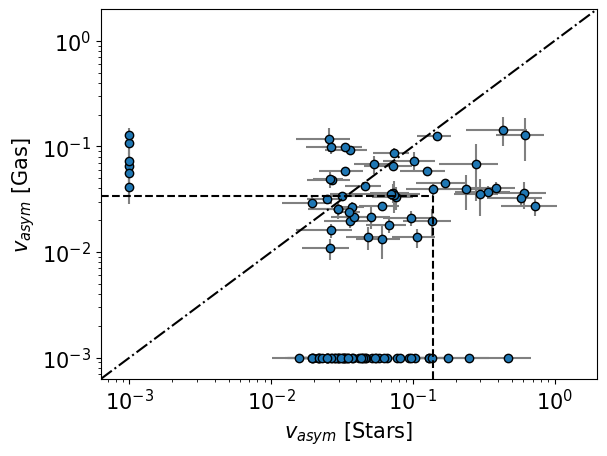

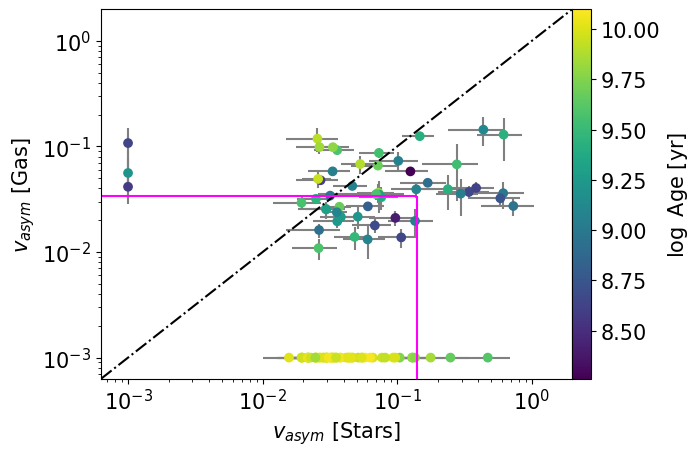

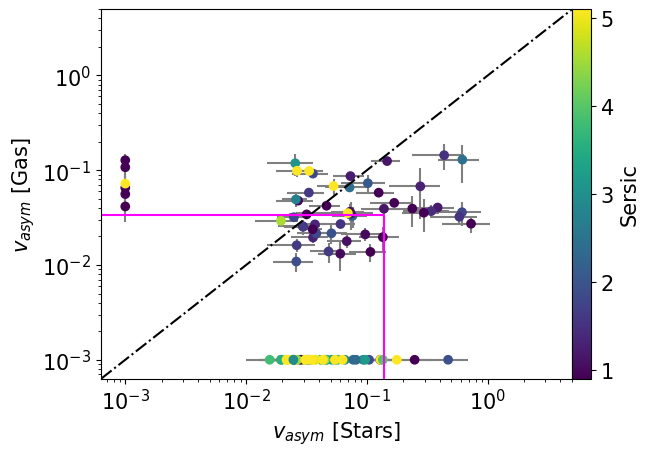

In [716]:
sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_s05.csv")
# onere = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_1Re.csv")
prospect = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
galfit = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_GalfitSersicCat_v0.1.csv")
ssp = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
bpt = pd.read_csv('/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv')
master = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_master_source_catalogue.csv",skiprows=16)
prospect = prospect[prospect['MAGPIID'].isin(sample["MAGPIID"])]
galfit = galfit[galfit["MAGPIID"].isin(sample["MAGPIID"])]
bpt = bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
ssp = ssp[ssp["MAGPIID"].isin(sample["MAGPIID"])]
master = master[master['MAGPIID'].isin(sample["MAGPIID"])]
#sample = sample[sample["MAGPIID"].isin(onere["MAGPIID"])]

vs = sample["v_asym_s"].to_numpy()
vs_err=sample["v_asym_s_err"].to_numpy()
vg = sample["v_asym_g"].to_numpy()
vg_err=sample["v_asym_g_err"].to_numpy()
age = ssp["logage_LW_1re"].to_numpy()

vs_err[np.isnan(vs)]=0
vg_err[np.isnan(vg)]=0
vs[np.isnan(vs)]=1e-3
vg[np.isnan(vg)]=1e-3

fig,ax=plt.subplots()
p=ax.scatter(vs,vg,ec="k",zorder=2)
ax.errorbar(vs,vg,xerr=vs_err,yerr=vg_err,color="grey",ls='',zorder=1)
ax.plot(np.logspace(-3.2,0.7),np.logspace(-3.2,0.7),ls="dashdot",color="k")
ax.set_xlabel(r"$v_{asym}$ [Stars]")
ax.set_ylabel(r"$v_{asym}$ [Gas]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(10**(-3.2),10**(0.3))
ax.set_ylim(10**(-3.2),10**(0.3))
ax.vlines(x=np.std(vs[vs>2e-3]),ymin=10**(-3.2),ymax=np.std(vg[vg>2e-3]),color='k',ls="dashed")
ax.hlines(y=np.std(vg[vg>2e-3]),xmin=10**(-3.2),xmax=np.std(vs[vs>2e-3]),color="k",ls="dashed")
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/s05_gas_stars.pdf",bbox_inches="tight")

fig,ax=plt.subplots()
p=ax.scatter(vs,vg,c=age,zorder=2)
ax.errorbar(vs,vg,xerr=vs_err,yerr=vg_err,color="grey",ls='',zorder=1)
ax.plot(np.logspace(-3.2,0.7),np.logspace(-3.2,0.7),ls="dashdot",color="k")
ax.set_xlabel(r"$v_{asym}$ [Stars]")
ax.set_ylabel(r"$v_{asym}$ [Gas]")
ax.set_xscale("log")
ax.set_yscale("log")
cbar = plt.colorbar(p,ax=ax,fraction=0.05,pad=0.00,label=r"$\log$ Age [yr]")
ax.set_xlim(10**(-3.2),10**(0.3))
ax.set_ylim(10**(-3.2),10**(0.3))
ax.vlines(x=np.std(vs[vs>2e-3]),ymin=10**(-3.2),ymax=np.std(vg[vg>2e-3]),color='magenta')
ax.hlines(y=np.std(vg[vg>2e-3]),xmin=10**(-3.2),xmax=np.std(vs[vs>2e-3]),color="magenta")
#cbar.ax.set_yticklabels([8.95,9.05,9.15,9.25,9.35,9.45,9.55,9.65,9.75])
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/s05_gas_stars_age.pdf",bbox_inches="tight")

fig,ax=plt.subplots()
p=ax.scatter(vs,vg,c=galfit["n"],vmin=0.9,vmax=5.1,zorder=2)
ax.errorbar(vs,vg,xerr=vs_err,yerr=vg_err,color="grey",ls='',zorder=1)
ax.plot(np.logspace(-3.2,0.7),np.logspace(-3.2,0.7),ls="dashdot",color="k")
ax.set_xlabel(r"$v_{asym}$ [Stars]")
ax.set_ylabel(r"$v_{asym}$ [Gas]")
ax.set_xscale("log")
ax.set_yscale("log")
plt.colorbar(p,ax=ax,fraction=0.05,pad=0.00,label="Sersic")
ax.set_xlim(10**(-3.2),10**(0.7))
ax.set_ylim(10**(-3.2),10**(0.7))
ax.vlines(x=np.std(vs[vs>2e-3]),ymin=10**(-3.2),ymax=np.std(vg[vg>2e-3]),color='magenta')
ax.hlines(y=np.std(vg[vg>2e-3]),xmin=10**(-3.2),xmax=np.std(vs[vs>2e-3]),color="magenta")
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/s05_gas_stars_sersic.pdf",bbox_inches="tight")

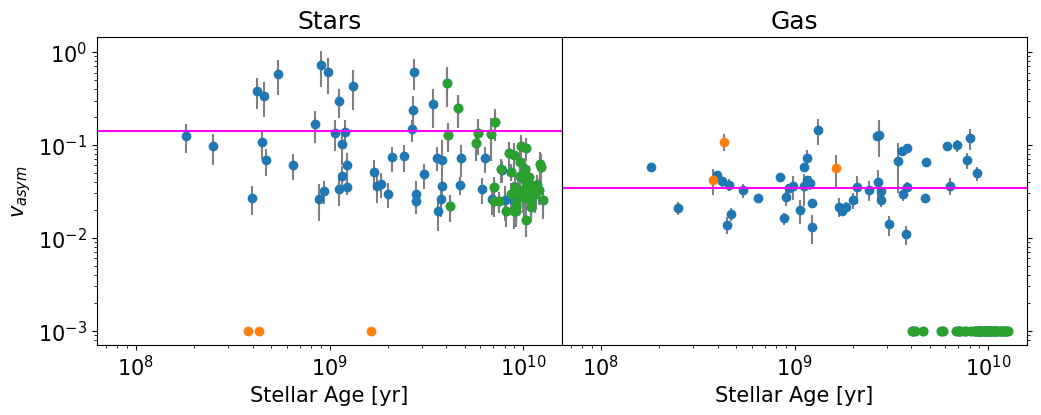

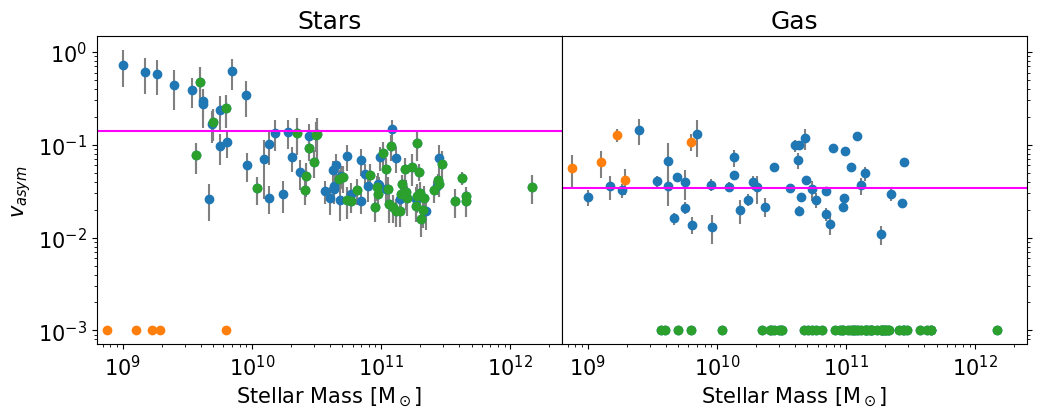

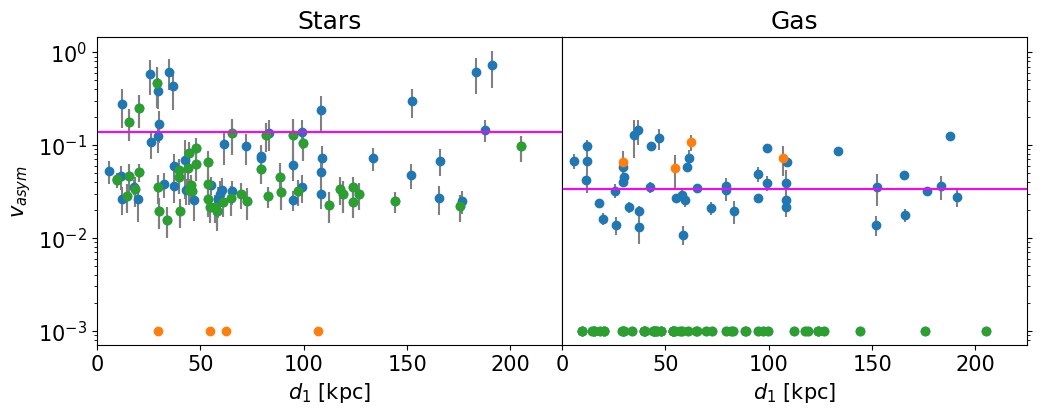

In [717]:
fig,(ax1,ax2) = plt.subplots(1,2,sharey="row",figsize=(12,4))
ax1.scatter(10**(age[vs>2e-3]),vs[vs>2e-3],zorder=2)
ax1.errorbar(10**(age[vs>2e-3]),vs[vs>2e-3],yerr=vs_err[vs>2e-3],ls="",color="grey",zorder=1)
ax1.scatter(10**(age[vs<2e-3]),vs[vs<2e-3],zorder=2)
ax1.errorbar(10**(age[vs<2e-3]),vs[vs<2e-3],yerr=vs_err[vs<2e-3],ls="",color="grey",zorder=1)
ax1.scatter(10**(age[vg<2e-3]),vs[vg<2e-3],zorder=2)
ax1.errorbar(10**(age[vg<2e-3]),vs[vg<2e-3],yerr=vs_err[vg<2e-3],ls="",color="grey",zorder=1)
ax2.scatter(10**(age[vs>2e-3]),vg[vs>2e-3],zorder=2)
ax2.errorbar(10**(age[vs>2e-3]),vg[vs>2e-3],yerr=vg_err[vs>2e-3],ls="",color="grey",zorder=1)
ax2.scatter(10**(age[vs<2e-3]),vg[vs<2e-3],zorder=2)
ax2.errorbar(10**(age[vs<2e-3]),vg[vs<2e-3],yerr=vg_err[vs<2e-3],ls="",color="grey",zorder=1)
ax2.scatter(10**(age[vg<2e-3]),vg[vg<2e-3],zorder=2)
ax2.errorbar(10**(age[vg<2e-3]),vg[vg<2e-3],yerr=vg_err[vg<2e-3],ls="",color="grey",zorder=1)
ax1.hlines(y=np.std(vs[vs>2e-3]),xmin=10**7,xmax=10**12,color="magenta")
ax2.hlines(y=np.std(vg[vg>2e-3]),xmin=10**7,xmax=10**12,color="magenta")
for ax in [ax1,ax2]:
    ax.set_xlim(10**(7.8),10**(10.2))
ax2.set_yscale("log")
ax1.set_xscale("log")
ax2.set_xscale("log")
ax1.set_title("Stars")
ax2.set_title("Gas")
ax1.set_ylabel(r"$v_{asym}$")
ax1.set_xlabel(r"Stellar Age [yr]")
ax2.set_xlabel(r"Stellar Age [yr]")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.subplots_adjust(wspace=0)
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/asym_vs_age.pdf",bbox_inches="tight")

mass = prospect["StellarMass_median"].to_numpy()
fig,(ax1,ax2) = plt.subplots(1,2,sharey="row",figsize=(12,4))
ax1.scatter(mass[vs>2e-3],vs[vs>2e-3],zorder=2)
ax1.errorbar(mass[vs>2e-3],vs[vs>2e-3],yerr=vs_err[vs>2e-3],ls="",color="grey",zorder=1)
ax1.scatter(mass[vs<2e-3],vs[vs<2e-3],zorder=2)
ax1.errorbar(mass[vs<2e-3],vs[vs<2e-3],yerr=vs_err[vs<2e-3],ls="",color="grey",zorder=1)
ax1.scatter(mass[vg<2e-3],vs[vg<2e-3],zorder=2)
ax1.errorbar(mass[vg<2e-3],vs[vg<2e-3],yerr=vs_err[vg<2e-3],ls="",color="grey",zorder=1)
ax2.scatter(mass[vs>2e-3],vg[vs>2e-3],zorder=2)
ax2.errorbar(mass[vs>2e-3],vg[vs>2e-3],yerr=vg_err[vs>2e-3],ls="",color="grey",zorder=1)
ax2.scatter(mass[vs<2e-3],vg[vs<2e-3],zorder=2)
ax2.errorbar(mass[vs<2e-3],vg[vs<2e-3],yerr=vg_err[vs<2e-3],ls="",color="grey",zorder=1)
ax2.scatter(mass[vg<2e-3],vg[vg<2e-3],zorder=2)
ax2.errorbar(mass[vg<2e-3],vg[vg<2e-3],yerr=vg_err[vg<2e-3],ls="",color="grey",zorder=1)
ax1.hlines(y=np.std(vs[vs>2e-3]),xmin=10**7,xmax=10**13,color="magenta")
ax2.hlines(y=np.std(vg[vg>2e-3]),xmin=10**7,xmax=10**13,color="magenta")
for ax in [ax1,ax2]:
    ax.set_xlim(10**(8.8),10**(12.4))
ax2.set_yscale("log")
ax2.set_xscale("log")
ax1.set_xscale("log")
ax1.set_title("Stars")
ax2.set_title("Gas")
ax1.set_ylabel(r"$v_{asym}$")
ax1.set_xlabel(r"Stellar Mass [M$_\odot$]")
ax2.set_xlabel(r"Stellar Mass [M$_\odot$]")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.subplots_adjust(wspace=0)
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/asym_vs_mass.pdf",bbox_inches="tight")

env = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/kinemetry_sample_env.csv")
env = env[env["MAGPIID"].isin(sample["MAGPIID"])]
env_sample = sample[sample["MAGPIID"].isin(env["MAGPIID"])]
vs = env_sample["v_asym_s"].to_numpy()
vs_err=env_sample["v_asym_s_err"].to_numpy()
vg = env_sample["v_asym_g"].to_numpy()
vg_err=env_sample["v_asym_g_err"].to_numpy()
d1 = env["d1,kpc"].to_numpy()
fig,(ax1,ax2) = plt.subplots(1,2,sharey="row",figsize=(12,4))
ax1.scatter(d1[vs>2e-3],vs[vs>2e-3],zorder=2)
ax1.errorbar(d1[vs>2e-3],vs[vs>2e-3],yerr=vs_err[vs>2e-3],ls="",color="grey",zorder=1)
ax1.scatter(d1[vs<2e-3],vs[vs<2e-3],zorder=2)
ax1.errorbar(d1[vs<2e-3],vs[vs<2e-3],yerr=vs_err[vs<2e-3],ls="",color="grey",zorder=1)
ax1.scatter(d1[vg<2e-3],vs[vg<2e-3],zorder=2)
ax1.errorbar(d1[vg<2e-3],vs[vg<2e-3],yerr=vs_err[vg<2e-3],ls="",color="grey",zorder=1)
ax2.scatter(d1[vs>2e-3],vg[vs>2e-3],zorder=2)
ax2.errorbar(d1[vs>2e-3],vg[vs>2e-3],yerr=vg_err[vs>2e-3],ls="",color="grey",zorder=1)
ax2.scatter(d1[vs<2e-3],vg[vs<2e-3],zorder=2)
ax2.errorbar(d1[vs<2e-3],vg[vs<2e-3],yerr=vg_err[vs<2e-3],ls="",color="grey",zorder=1)
ax2.scatter(d1[vg<2e-3],vg[vg<2e-3],zorder=2)
ax2.errorbar(d1[vg<2e-3],vg[vg<2e-3],yerr=vg_err[vg<2e-3],ls="",color="grey",zorder=1)
ax1.hlines(y=np.std(vs[vs>2e-3]),xmin=0,xmax=250,color="magenta")
ax2.hlines(y=np.std(vg[vg>2e-3]),xmin=0,xmax=250,color="magenta")
for ax in [ax1,ax2]:
    ax.set_xlim(0,225)
ax2.set_yscale("log")
#ax2.set_xscale("log")
#ax1.set_xscale("log")
ax1.set_title("Stars")
ax2.set_title("Gas")
ax1.set_ylabel(r"$v_{asym}$")
ax1.set_xlabel(r"$d_1$ [kpc]")
ax2.set_xlabel(r"$d_1$ [kpc]")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.subplots_adjust(wspace=0)
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/asym_vs_d1.pdf",bbox_inches="tight")

In [718]:
env = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/kinemetry_sample_env.csv")

master = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/"
                     "MAGPI_master_source_catalogue.csv",skiprows=16)
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
#master = master[master["MAGPIID"].isin(sample["MAGPIID"])]
gal = np.zeros(len(env))
d1_ = np.zeros(len(env))
for i in range(len(env)):
    group = env[env['GroupName'].isin([env["GroupName"].to_numpy()[i]])]
    group_master = master[master["MAGPIID"].isin(group["MAGPIID"])]
    #print([env_sample['MAGPIID'].to_numpy()[i]])
    sample_master = master[master['MAGPIID'].isin([env['MAGPIID'].to_numpy()[i]])]
    x = group_master["xmax"].to_numpy()
    y = group_master["ymax"].to_numpy()
    #print(x,y)
    x0 = sample_master["xmax"].to_numpy()[0]
    y0 = sample_master["ymax"].to_numpy()[0]
    z = sample_master["z"].to_numpy()[0]
    gal[i] = sample_master["MAGPIID"].to_numpy()[0]
    #print(x0,y0)
    d1 = np.sqrt((x-x0)**2 + (y-y0)**2)
    d1 = np.min(d1[d1>0])
    cd = cosmo.comoving_distance(z).to(u.kpc).value
    d1 = np.radians(d1*(0.2/3600))
    d1 = d1*cd
    d1_[i] = d1
env["d1,kpc"] = d1_
env.to_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/kinemetry_sample_env.csv")

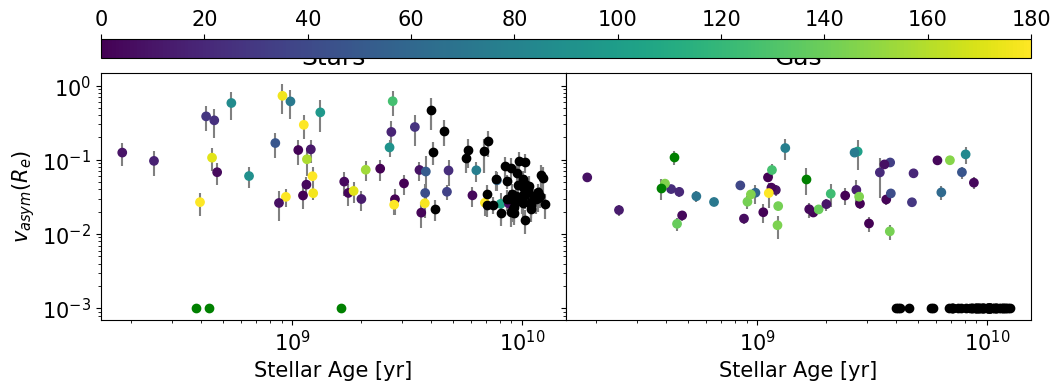

In [719]:
dpa =pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_1Re.csv")
sample = sample[sample["MAGPIID"].isin(dpa["MAGPIID"])]
ssp = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
ssp = ssp[ssp["MAGPIID"].isin(dpa["MAGPIID"])]
vs = sample["v_asym_s"].to_numpy()
vs_err=sample["v_asym_s_err"].to_numpy()
vg = sample["v_asym_g"].to_numpy()
vg_err=sample["v_asym_g_err"].to_numpy()
age = ssp["logage_LW_1re"].to_numpy()
vs_err[np.isnan(vs)]=0
vg_err[np.isnan(vg)]=0
vs[np.isnan(vs)]=1e-3
vg[np.isnan(vg)]=1e-3
fig,ax = plt.subplots(1,2,figsize=(12,4),sharey="row")
p=ax[0].scatter(10**(age[vs>2e-3]),vs[vs>2e-3],zorder=2,c=dpa['D_PA'].to_numpy()[vs>2e-3],vmin=0,vmax=180)
ax[0].errorbar(10**(age[vs>2e-3]),vs[vs>2e-3],yerr=vs_err[vs>2e-3],ls="",color="grey",zorder=1)
ax[0].scatter(10**(age[vs<2e-3]),vs[vs<2e-3],c="g",zorder=2)
ax[0].errorbar(10**(age[vs<2e-3]),vs[vs<2e-3],yerr=vs_err[vs<2e-3],ls="",color="grey",zorder=1)
ax[0].scatter(10**(age[vg<2e-3]),vs[vg<2e-3],c="k",zorder=2)
ax[0].errorbar(10**(age[vg<2e-3]),vs[vg<2e-3],yerr=vs_err[vg<2e-3],ls="",color="grey",zorder=1)
ax[1].scatter(10**(age[vs>2e-3]),vg[vs>2e-3],zorder=2,c=dpa['D_PA'].to_numpy()[vs>2e-3])
ax[1].errorbar(10**(age[vs>2e-3]),vg[vs>2e-3],yerr=vg_err[vs>2e-3],ls="",color="grey",zorder=1)
ax[1].scatter(10**(age[vs<2e-3]),vg[vs<2e-3],c="g",zorder=2)
ax[1].errorbar(10**(age[vs<2e-3]),vg[vs<2e-3],yerr=vg_err[vs<2e-3],ls="",color="grey",zorder=1)
ax[1].scatter(10**(age[vg<2e-3]),vg[vg<2e-3],c="k",zorder=2)
ax[1].errorbar(10**(age[vg<2e-3]),vg[vg<2e-3],yerr=vg_err[vg<2e-3],ls="",color="grey",zorder=1)
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[0].set_title("Stars")
ax[1].set_title("Gas")
ax[0].set_ylabel(r"$v_{asym}(R_e)$")
ax[0].set_xlabel(r"Stellar Age [yr]")
ax[1].set_xlabel(r"Stellar Age [yr]")
plt.subplots_adjust(wspace=0)
plt.colorbar(p,ax=ax,location="top",aspect=50)
plt.show()

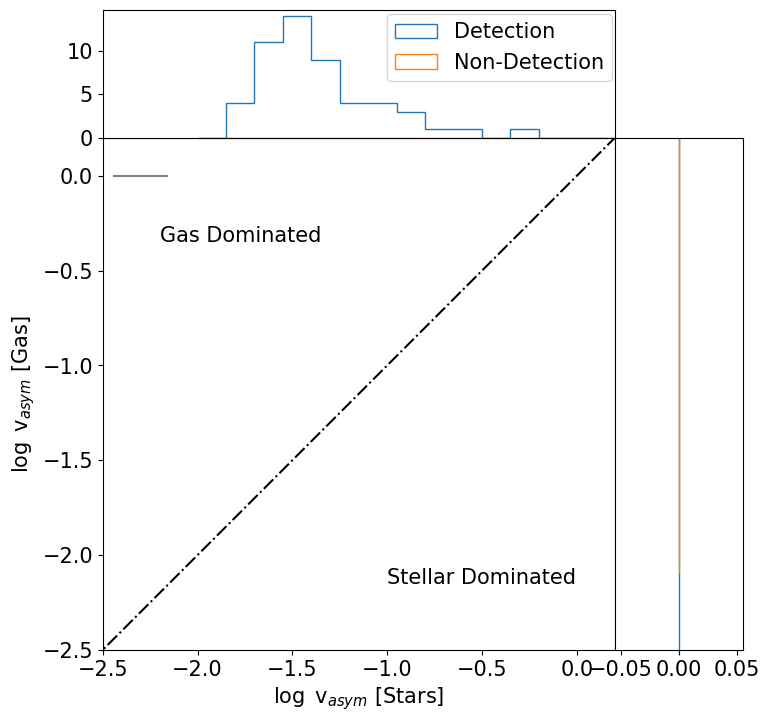

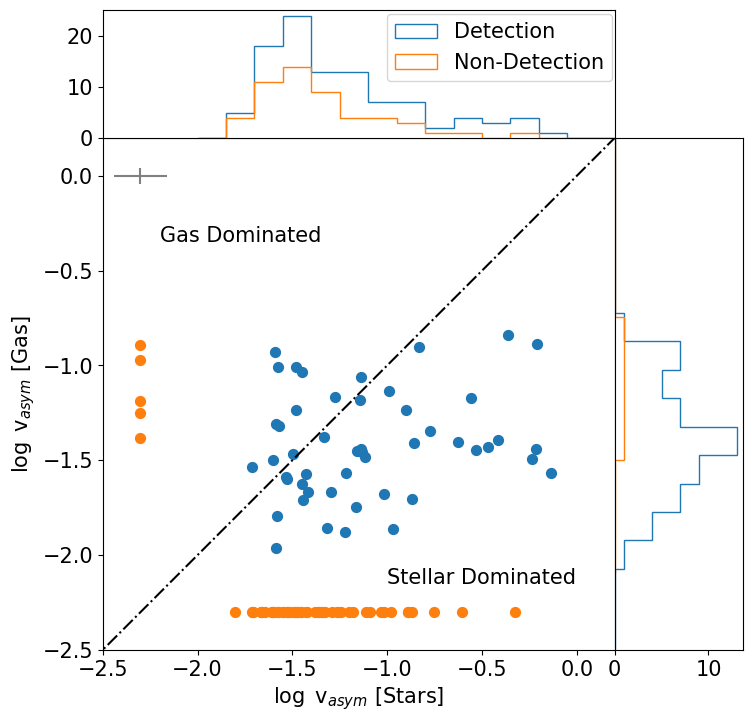

In [720]:
vs = sample["v_asym_s"].to_numpy()
vs_err=sample["v_asym_s_err"].to_numpy()
vg = sample["v_asym_g"].to_numpy()
vg_err=sample["v_asym_g_err"].to_numpy()
vs[vs==1e-3]=5e-3
vg[vg==1e-3]=5e-3
xerr = vs_err/((np.log(10)*(vs)))
yerr = vg_err/((np.log(10)*(vg)))
xerr = np.nanmean(xerr)
yerr = np.nanmean(yerr)
plt.rcParams.update({"font.size":15})

fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[1,0])
p=ax.scatter(np.log10(vs[(vs>8e-3) & (vg>8e-3)]),np.log10(vg[(vs>8e-3) & (vg>8e-3)]),s=50)
ax.scatter(np.log10(vs[(vs>8e-3) & (vg<8e-3)]),np.log10(vg[(vs>8e-3) & (vg<8e-3)]),s=50)
ax.scatter(np.log10(vs[(vs<8e-3) & (vg>8e-3)]),np.log10(vg[(vs<8e-3) & (vg>8e-3)]),s=50,c="tab:orange")
ax.errorbar(np.log10(5e-3),0,xerr=xerr,yerr=yerr,color="grey",ls="")
ax.plot(np.linspace(-3.3,1),np.linspace(-3.3,1),ls="dashdot",color="k")
ax.set_xlabel(r"$\log$ v$_{asym}$ [Stars]")
ax.text(s="Gas Dominated",x=-2.2,y=-0.35)
ax.text(s="Stellar Dominated",x=-1,y=-2.15)
ax.set_ylabel(r"$\log$ v$_{asym}$ [Gas]")
ax_histx = fig.add_subplot(gs[0,0])
ax_histx.hist(np.log10(vs[vs>8e-3]),histtype="step",bins=np.arange(-2,0.65,0.15),
              label="Detection")
ax_histx.hist(np.log10(vs[vg<8e-3]),histtype="step",bins=np.arange(-2,0.65,0.15),
              label="Non-Detection")
ax_histx.set_xticks([])
ax_histx.legend(bbox_to_anchor=(1.015,1.05))
ax_histy = fig.add_subplot(gs[1,1])
ax_histy.hist(np.log10(vg[vg>8e-3]),histtype="step",orientation="horizontal",
              bins=np.arange(np.log10(3e-3),0.65,0.15))
ax_histy.hist(np.log10(vg[vs<8e-3]),histtype="step",orientation="horizontal",
              bins=np.arange(np.log10(8e-3),0.65,0.15))
ax_histy.set_yticks([])
ax.set_xlim(-2.5,0.2)
ax.set_ylim(-2.5,0.2)
ax_histx.set_xlim(-2.5,0.2)
ax_histy.set_ylim(-2.5,0.2)
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper2/asym_s_g.pdf",bbox_inches="tight")

In [721]:
bpt["type(sf=1, sy=2, ln=3) SII"]

0      1.0
1      2.0
2      1.0
3      1.0
4      1.0
      ... 
102    1.0
103    1.0
104    1.0
105    1.0
106    1.0
Name: type(sf=1, sy=2, ln=3) SII, Length: 107, dtype: float64

In [722]:
import astropy
file = fits.open("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/pa_gas_results.fits")
#file.info()
table = astropy.table.Table(file[1].data)
csv = table.write("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_gas_PA.csv",
                  overwrite=True)
file = fits.open("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/pa_stellar_results.fits")
#file.info()
table = astropy.table.Table(file[1].data)
csv = table.write("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_stellar_PA.csv",
                  overwrite=True)

In [723]:
sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_S05.csv")
gas_pa = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_gas_PA.csv")
stars_pa = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_stellar_PA.csv")
gas_pa = gas_pa[gas_pa["ID"].isin(sample["MAGPIID"])]
stars_pa = stars_pa[stars_pa["ID"].isin(sample["MAGPIID"])]
gas_pa = gas_pa[gas_pa["ID"].isin(stars_pa["ID"])]
pa_sample = sample[sample['MAGPIID'].isin(stars_pa["ID"])]
pa_ssp = ssp[ssp['MAGPIID'].isin(pa_sample["MAGPIID"])]

In [724]:
dpa =[]
for i in range(len(sample)):
    if np.isnan(sample['v_asym_s'].to_numpy()[i]) or np.isnan(sample["v_asym_g"].to_numpy()[i]):
        dpa.append(np.nan)
    else:
        gpa = gas_pa[gas_pa["ID"].isin([sample['MAGPIID'].to_numpy()[i]])]
        spa = stars_pa[stars_pa["ID"].isin([sample['MAGPIID'].to_numpy()[i]])]
        if len(gpa)==0 or len(spa)==0:
            dpa.append(np.nan)
        else:
            dpa.append(abs(gpa["PA_gas"].to_numpy() - spa["PA_stars"].to_numpy()))
print(len(dpa))
sample["DPA"]=dpa

107


/var/folders/hn/phg07l9934x4013mnrp122c40000gn/T/ipykernel_8734/2497667831.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  p=ax[0].scatter(10**(age[vs>2e-3]),vs[vs>2e-3],zorder=2,vmin=0,vmax=50)


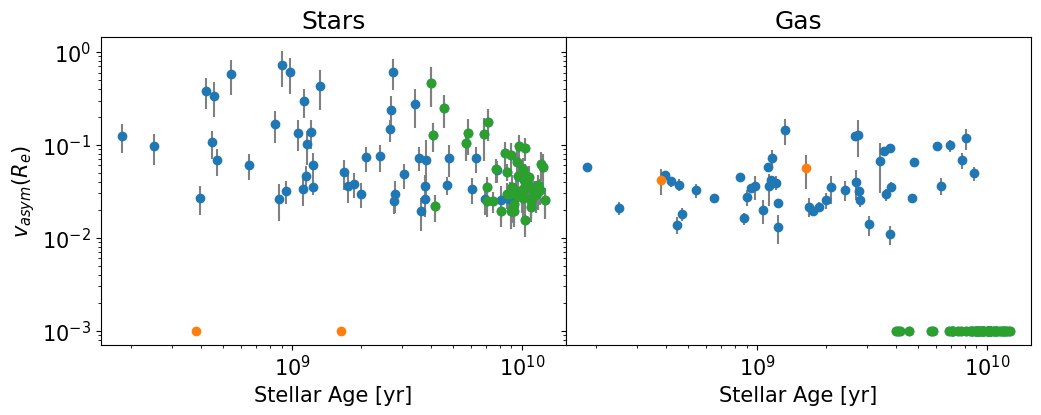

In [725]:
ssp = ssp[ssp["MAGPIID"].isin(pa_sample["MAGPIID"])]
vs = pa_sample["v_asym_s"].to_numpy()
vs_err=pa_sample["v_asym_s_err"].to_numpy()
vg = pa_sample["v_asym_g"].to_numpy()
vg_err=pa_sample["v_asym_g_err"].to_numpy()
age = pa_ssp["logage_LW_1re"].to_numpy()
vs_err[np.isnan(vs)]=0
vg_err[np.isnan(vg)]=0
vs[np.isnan(vs)]=1e-3
vg[np.isnan(vg)]=1e-3
fig,ax = plt.subplots(1,2,figsize=(12,4),sharey="row")
p=ax[0].scatter(10**(age[vs>2e-3]),vs[vs>2e-3],zorder=2,vmin=0,vmax=50)
ax[0].errorbar(10**(age[vs>2e-3]),vs[vs>2e-3],yerr=vs_err[vs>2e-3],ls="",color="grey",zorder=1)
ax[0].scatter(10**(age[vs<2e-3]),vs[vs<2e-3],zorder=2)
ax[0].errorbar(10**(age[vs<2e-3]),vs[vs<2e-3],yerr=vs_err[vs<2e-3],ls="",color="grey",zorder=1)
ax[0].scatter(10**(age[vg<2e-3]),vs[vg<2e-3],zorder=2)
ax[0].errorbar(10**(age[vg<2e-3]),vs[vg<2e-3],yerr=vs_err[vg<2e-3],ls="",color="grey",zorder=1)
ax[1].scatter(10**(age[vs>2e-3]),vg[vs>2e-3],zorder=2)
ax[1].errorbar(10**(age[vs>2e-3]),vg[vs>2e-3],yerr=vg_err[vs>2e-3],ls="",color="grey",zorder=1)
ax[1].scatter(10**(age[vs<2e-3]),vg[vs<2e-3],zorder=2)
ax[1].errorbar(10**(age[vs<2e-3]),vg[vs<2e-3],yerr=vg_err[vs<2e-3],ls="",color="grey",zorder=1)
ax[1].scatter(10**(age[vg<2e-3]),vg[vg<2e-3],zorder=2)
ax[1].errorbar(10**(age[vg<2e-3]),vg[vg<2e-3],yerr=vg_err[vg<2e-3],ls="",color="grey",zorder=1)
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[0].set_title("Stars")
ax[1].set_title("Gas")
ax[0].set_ylabel(r"$v_{asym}(R_e)$")
ax[0].set_xlabel(r"Stellar Age [yr]")
ax[1].set_xlabel(r"Stellar Age [yr]")
plt.subplots_adjust(wspace=0)
#plt.colorbar(p,ax=ax,location="top",aspect=50)
plt.show()

KeyError: 'DPA'

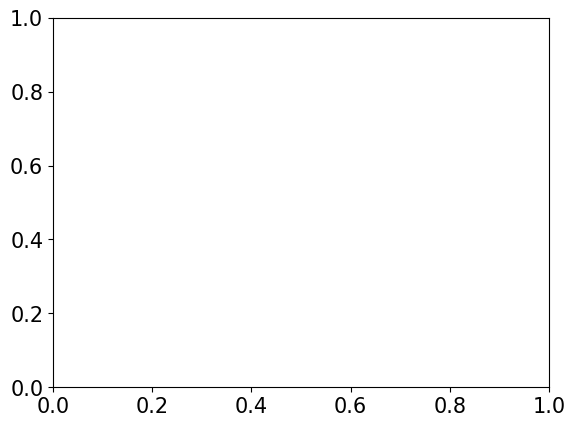

In [726]:
fig,ax = plt.subplots()
p=ax.scatter(vs,vg,c=pa_sample["DPA"].to_numpy(),vmin=0,vmax=50,zorder=2,s=50)
ax.errorbar(vs,vg,xerr=vs_err,yerr=vg_err,ls="",color="grey",marker="v",zorder=1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(np.logspace(-4,2),np.logspace(-4,2),ls="dashed",color="k")
ax.set_xlim(8e-3,1.2)
ax.set_ylim(8e-3,1.2)
ax.set_xlabel(r"v$_{\rm asym}$ [Stars]")
ax.set_ylabel(r"v$_{\rm asym}$ [Gas]")
plt.colorbar(p,ax=ax,label=r"$\Delta$PA")
plt.show()

In [ ]:
sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_s05.csv")
sample = sample[np.isnan(sample["v_asym_g"])]
prospect = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
ssp = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
env = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/kinemetry_sample_env.csv")
env_sample = sample[sample["MAGPIID"].isin(env["MAGPIID"])]
# env_sample = env_sample[(env_sample["v_asym_s"]>np.std(vs[vs>2e-3])) &
#                         (env_sample["v_asym_g"]>np.std(vg[vg>2e-3]))]
env = env[env["MAGPIID"].isin(env_sample["MAGPIID"])]
ssp = ssp[ssp["MAGPIID"].isin(env_sample["MAGPIID"])]
prospect = prospect[prospect["MAGPIID"].isin(env_sample["MAGPIID"])]
print(env_sample["MAGPIID"].to_numpy())
print(env["d1,kpc"].to_numpy())
print(ssp["logage_LW_1re"].to_numpy())
print(prospect["StellarMass_median"].to_numpy())
print(env["BCG?"].to_numpy())
print(np.max(np.log10(prospect["StellarMass_median"].to_numpy())) - np.min(np.log10(prospect["StellarMass_median"].to_numpy())))

In [ ]:
fig,ax =plt.subplots()
ax.scatter(prospect["StellarMass_median"],env_sample["v_asym_s"])
ax.scatter(prospect["StellarMass_median"],env_sample["v_asym_g"])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-3,0.8)
ax.set_xlim(8.8e8,8e11)
plt.show()
fig,ax =plt.subplots()
ax.scatter(10**(ssp["logage_LW_1re"]),env_sample["v_asym_s"])
ax.scatter(10**(ssp["logage_LW_1re"]),env_sample["v_asym_g"])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-3,0.8)
ax.set_xlim(8e7,2e10)
plt.show()

fig,ax =plt.subplots()
ax.scatter(env["d1,kpc"],env_sample["v_asym_s"])
ax.scatter(env["d1,kpc"],env_sample["v_asym_g"])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-3,0.8)
#ax.set_xlim(8e7,2e10)
plt.show()

In [ ]:
fig,ax = plt.subplots()
ax.scatter(vs,vg)
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(np.logspace(-4,1),np.logspace(-4,1),ls="dashed",color="k")
ax.vlines(x=np.std(vs[vs>2e-3]),ymin=10**(-3.2),ymax=np.std(vg[vg>2e-3]),color='k',ls="dashed")
ax.hlines(y=np.std(vg[vg>2e-3]),xmin=10**(-3.2),xmax=np.std(vs[vs>2e-3]),color="k",ls="dashed")
ax.set_xlim(8e-4,1.5)
ax.set_ylim(8e-4,1.5)
ax.set_ylabel(r"v$_{asym}$ [Gas]")
ax.set_xlabel(r"v$_{asym}$ [Stars]")
plt.show()

fig,ax = plt.subplots()
ax.scatter(vs,vg,c="k",alpha=0.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(np.logspace(-4,1),np.logspace(-4,1),ls="dashed",color="k")
ax.text(s="Gas Dominated",x=2e-3,y=1e-1)
ax.text(s="Stellar Dominated",x=4.8e-2,y=2e-3)
#ax.text(s="Stellar Dominated",x=2e-3,y=1e-1)
#ax.text(s="Merger\nDriven",x=2e-1,y=8e-3)
ax.vlines(x=np.std(vs[vs>2e-3]),ymin=10**(-3.2),ymax=np.std(vg[vg>2e-3]),color='k',ls="dashed")
ax.hlines(y=np.std(vg[vg>2e-3]),xmin=10**(-3.2),xmax=np.std(vs[vs>2e-3]),color="k",ls="dashed")
ax.set_xlim(8e-4,1.5)
ax.set_ylim(8e-4,1.5)
ax.set_ylabel(r"v$_{asym}$ [Gas]")
ax.set_xlabel(r"v$_{asym}$ [Stars]")
plt.show()

fig,ax = plt.subplots()
ax.scatter(vs,vg,c="k",alpha=0.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(np.logspace(-4,1),np.logspace(-4,1),ls="dashed",color="k")
ax.text(s="Gas Dominated",x=2e-3,y=1e-1)
ax.text(s="Stellar Dominated",x=4.8e-2,y=2e-3)
#ax.text(s="Stellar Dominated",x=2e-3,y=1e-1)
ax.text(s="Merger\nDriven",x=2e-1,y=8e-3)
ax.text(s="Accretion\nDriven",x=4e-2,y=2e-1)
ax.vlines(x=np.std(vs[vs>2e-3]),ymin=10**(-3.2),ymax=np.std(vg[vg>2e-3]),color='k',ls="dashed")
ax.hlines(y=np.std(vg[vg>2e-3]),xmin=10**(-3.2),xmax=np.std(vs[vs>2e-3]),color="k",ls="dashed")
ax.set_xlim(8e-4,1.5)
ax.set_ylim(8e-4,1.5)
ax.set_ylabel(r"v$_{asym}$ [Gas]")
ax.set_xlabel(r"v$_{asym}$ [Stars]")
plt.show()

103

In [740]:
sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_s05.csv")
prospect = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
sample = sample.dropna()
prospect = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]

vs = sample["v_asym_s"].to_numpy()
#vs = vs[~np.isnan(vs)]
vg = sample["v_asym_g"].to_numpy()
#vg = vg[~np.isnan(vg)]
len(sample[vs>vg])/len(sample)

0.7551020408163265

In [741]:
scipy.stats.pearsonr(np.log10(vs),np.log10(prospect["StellarMass_median"]))

PearsonRResult(statistic=-0.7450117163523713, pvalue=8.318741911589156e-10)

In [743]:
scipy.stats.pearsonr(np.log10(vg),np.log10(prospect["StellarMass_median"]))

PearsonRResult(statistic=0.009655063548750432, pvalue=0.9475034621209445)

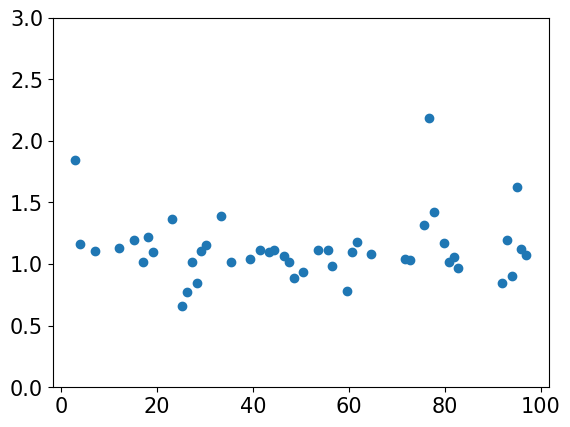

1.1217488177022321
0.25581570347240595


In [761]:
sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_s05_no_err.csv")
s05_s = np.sqrt((0.5*sample["V_rot_s"])**2 + sample["Sigma_s"]**2)
s05_g = np.sqrt((0.5*sample["V_rot_g"])**2 + sample["Sigma_g"]**2)

fig,ax = plt.subplots()
ax.scatter(np.linspace(0,len(sample),len(sample)),np.array(s05_s/s05_g))
ax.set_ylim(0,3)
plt.show()
print(np.nanmean(np.array(s05_s/s05_g)))
print(np.nanstd(np.array(s05_s/s05_g)))